# Validating PoolModel Data

I have a method to fetch what I believe will be the necessary data for the model from GNM_Pool.

Does the method work?
How does the data returned from that method look? 

In [1]:
import os
os.chdir("/home/charles/src/LondonMirror/Prepayments/")

In [2]:
import prepayments as pp
import numpy as np
import pandas as pd
import ggplot as gg
from datetime import datetime

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [3]:
pm = pp.models.PoolModel()

In [4]:
samples = [(pm.data_pool.h5file.root.pools[i]['pool_number'],
            datetime.fromtimestamp(pm.data_pool.h5file.root.pools[i]['as_of_date']))
           for i in np.random.choice(14151801,1000)]

In [5]:
ans = pm.data_for_pool_number(*samples[0])

In [6]:
ans

{'burnout': 61552.159999999982,
 'cato': -0.57029999999999981,
 'hpa': 0.13464922927376852,
 'incentive': 3847.3299999999999,
 'lockin': 0.00095299922098156318,
 'marginal_cpr': 0,
 'sato': -167.05382839000004,
 'seasonality': 7,
 'upfront_mip': 7.296153846153846}

What's up with cato, hpa, and marginal_cpr?

In [7]:
%debug pm.data_for_pool_number(*samples[0])

NOTE: Enter 'c' at the ipdb>  prompt to continue execution.
> <string>(1)<module>()

ipdb> s
--Call--
> /home/charles/src/LondonMirror/Prepayments/prepayments/models.py(27)data_for_pool_number()
     25         self.data_pool = GNM_Pool(path=pool_path)
     26 
---> 27     def data_for_pool_number(self, pool_number, dt):
     28         """ * Curve at Origination:
     29                 * pools.as_of_date, pools.pool_issue_date

ipdb> s
> /home/charles/src/LondonMirror/Prepayments/prepayments/models.py(55)data_for_pool_number()
     53                 * % of UPB of loans paid off (in Various table) +, I guess, repurchased, foreclosed, etc., in same table.
     54         """
---> 55         next_dt = dt + MonthBegin() #Year-month dates were stored as first of the month.
     56         if next_dt > pd.Timestamp.now():
     57             raise Exception("Too soon to use data from {:%Y-%m-%d}".format(dt))

ipdb> b 154
Breakpoint 1 at /home/charles/src/LondonMirror/Prepayments/prepaymen

Uh-oh. Is pct_upb_of_loans_paid_off usually empty?

In [8]:
pct_upb = [pm.data_pool.variouses_table[i]['pct_upb_of_loans_paid_off'] 
           for i in np.random.choice(len(pm.data_pool.variouses_table),1000)]

In [10]:
pct_upb = pd.DataFrame({'pct_upb':pct_upb})

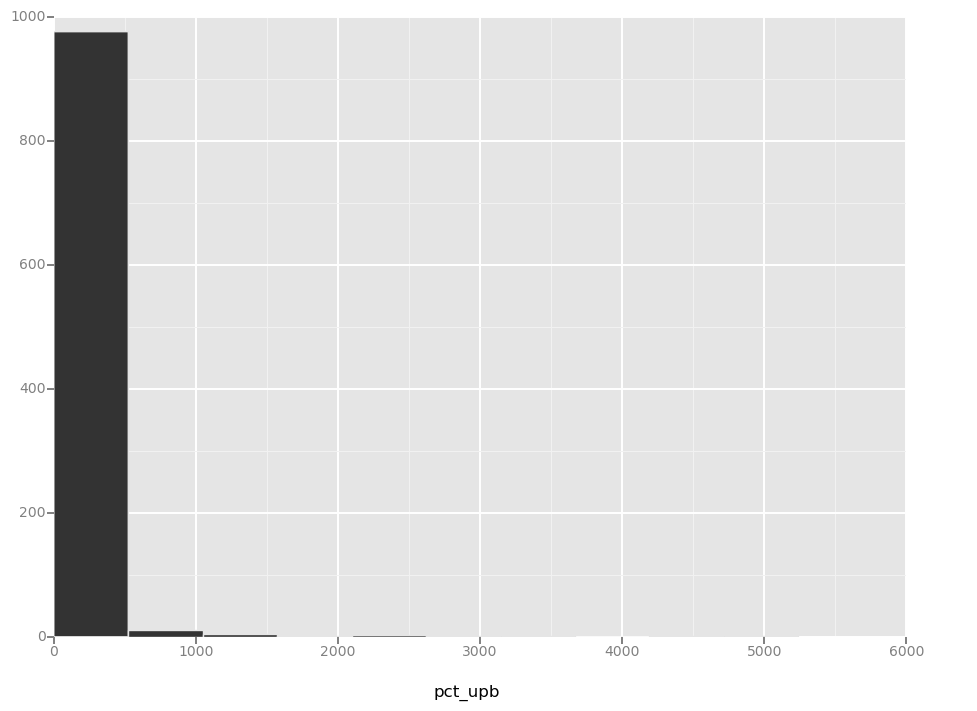

<ggplot: (8754842371013)>

In [11]:
gg.ggplot(pct_upb, gg.aes(x='pct_upb')) + gg.geom_histogram()

That's not a good source. Bugger. What about checking over the lifetime of a single pool?

In [13]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python2.7/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['record', 'datetime']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [17]:
pct_upb = {}
for i,dt in samples:
    pct_upb[i] = {}
    for record in pm.data_pool.variouses_table.where("pool_number == '{}'".format(i)):
        pct_upb[i][pp.models.dt_from_ts(record['as_of_date'])] = record['pct_upb_of_loans_paid_off']
    pct_upb[i] = pd.Series(pct_upb[i])
pct_upb = pd.DataFrame(pct_upb)

In [22]:
pct_upb.reset_index().info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59 entries, 0 to 58
Columns: 1001 entries, index to MA2645
dtypes: float64(269), int64(731), object(1)
memory usage: 461.5+ KB


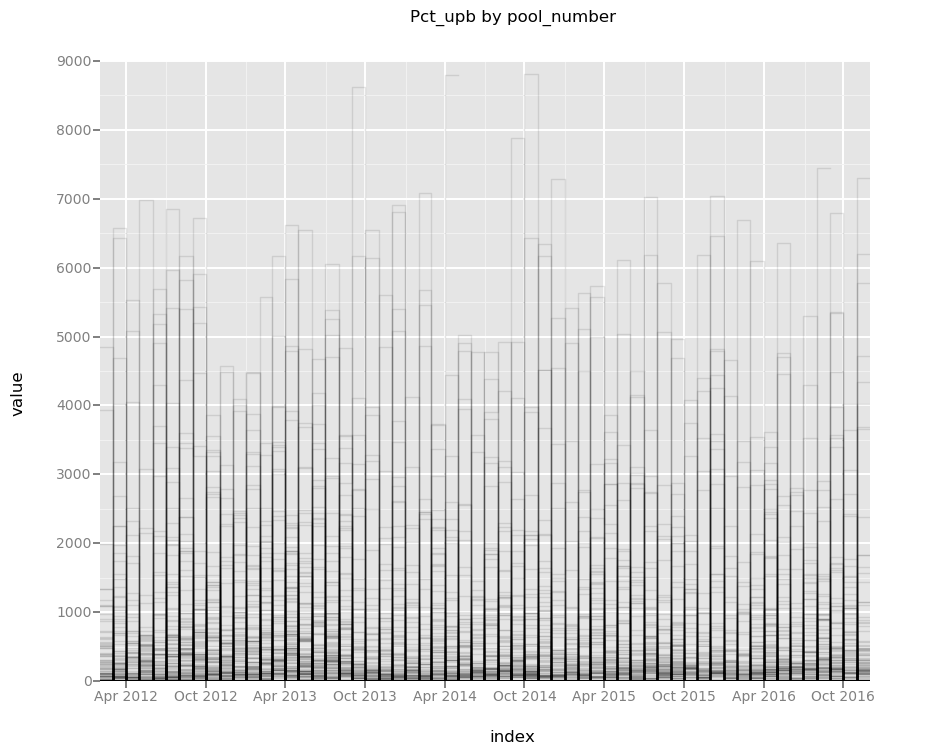

<ggplot: (8754761800069)>

In [27]:
gg.ggplot(pd.core.reshape.melt(pct_upb.reset_index(),id_vars=["index"]), 
          gg.aes(x="index",y="value",group="variable")) + gg.geom_step(alpha=0.1) + gg.ggtitle("Pct_upb by pool_number")

Data is inconsistent within pools, too, and there's no drift up. Maybe the basic UPB is there?

In [28]:
del(pct_upb)

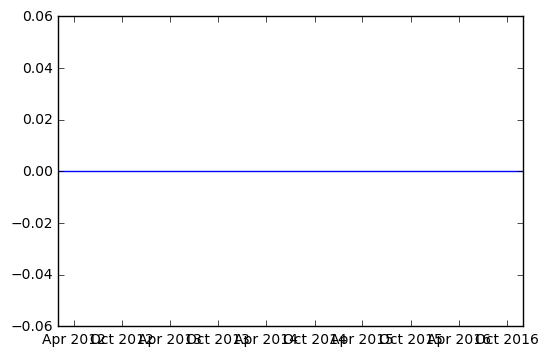

In [37]:
upb = {}
for record in pm.data_pool.variouses_table.where("pool_number == '{}'".format(samples[15][0])):
    upb[pp.models.dt_from_ts(record['as_of_date'])] = record['unpaid_principal_balance_of_loans_paid_off']
pd.Series(upb).plot()

In [41]:
bbg = pp.Bloomberg()
cpr = bbg.get_history("G2 6399169 Mtge", "MTG_HIST_COLLAT_CPR_1MO")
cpr

Series([], Name: G2 6399169 Mtge, dtype: float64)

In [39]:
pm.data_pool.pools_table.read_where("pool_number == '{}'".format(samples[15][0]))

array([ (5656050, 1328072400, '36291VCE1', 0, 0, 0, 5897100, 999, 97, 5870, 99999, 83, 360, 277, 0, 0, 0, 18000, 'Alabama Housing Finance Author Ity      ', 3977, 0, 0, 0, 0, 0, 0, 0, 5897100, 999, 97, 5890, 99999, 83, 360, 277, 5897100, 999, 97, 5890, 99999, 83, 360, 277, 5415000, 999, 97, 5870, 99999, 82, 360, 276, 0, 0, 0, 2, 2, 10000, 10137584, 18709100, 18000, 1, 1114920000, 2060654400, '639169', 'SF', 0, 0, 0, 0, 2, 10000, 10137584, 0, 0, 0, 5260, 9999, 5897100, 999, 97, 5890, 99999, 83, 360, 277, 5880, 99999, 82, 360, 277, 999, 0, 97),
       (5656050, 1330578000, '36291VCE1', 0, 0, 0, 5897100, 999, 97, 5870, 99999, 84, 360, 276, 0, 0, 0, 18000, 'Alabama Housing Finance Author Ity      ', 3977, 0, 0, 0, 0, 0, 0, 0, 5897100, 999, 97, 5890, 99999, 84, 360, 276, 5897100, 999, 97, 5890, 99999, 84, 360, 276, 5415000, 999, 97, 5870, 99999, 83, 360, 275, 0, 0, 0, 2, 2, 10000, 10112011, 18709100, 18000, 1, 1114920000, 2060654400, '639169', 'SF', 0, 0, 0, 0, 2, 10000, 10112011, 0, 0, 0, 

In [45]:
samples[15][0]

'639169'

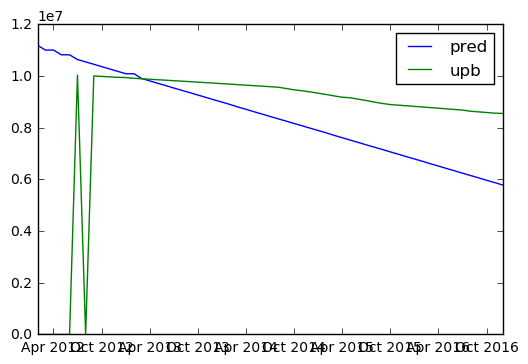

In [64]:
upb = {}
for record in pm.data_pool.pools_table.where("pool_number == '{}'".format(samples[15][0])):
    upb[pp.models.dt_from_ts(record['as_of_date'])] = {'upb':record['pool_upb'], 
                    'pred': record['original_aggregate_amount'] * (1 - record['wala'] * (record['wac'] / 1200000.))}
pd.DataFrame.from_dict(upb, orient='index').plot()

Hm. Maybe the % UPB of paid off loans isn't cumulative?

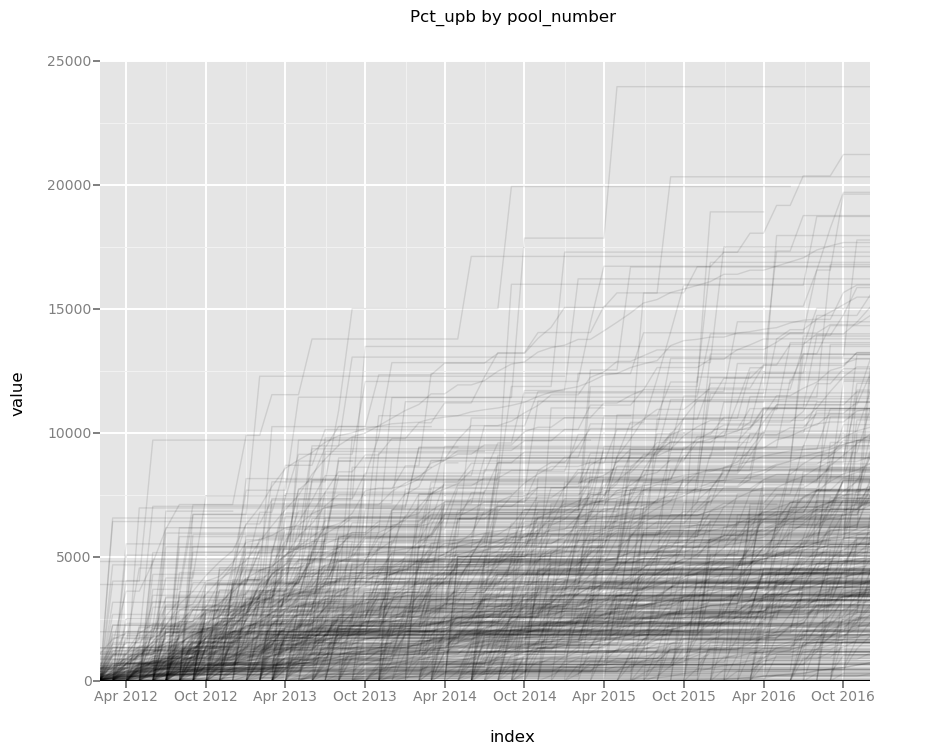

<ggplot: (8754845803513)>

In [69]:
pct_upb = {}
for i,dt in samples:
    pct_upb[i] = {}
    for record in pm.data_pool.variouses_table.where("pool_number == '{}'".format(i)):
        pct_upb[i][pp.models.dt_from_ts(record['as_of_date'])] = record['pct_upb_of_loans_paid_off']
    pct_upb[i] = pd.Series(pct_upb[i])
pct_upb = pd.DataFrame(pct_upb)

gg.ggplot(pd.core.reshape.melt(pct_upb.cumsum().reset_index(),id_vars=["index"]), 
          gg.aes(x="index",y="value",group="variable")) + gg.geom_line(alpha=0.1) + gg.ggtitle("Pct_upb by pool_number")

So what does it mean that so many of them go over 100%, then?

In [77]:
sum(pct_upb.cumsum().ix[-1,:] > 10000.) / float(pct_upb.shape[1])

0.079000000000000001

8%.

I suppose it's % of remaining UPB, so it'd need converting to % of original balance. Maybe the CPR conversion fixes it.

In [78]:
def smm_to_cpr(x):
    return 100*(1 - (1 - x/10000.)**12)

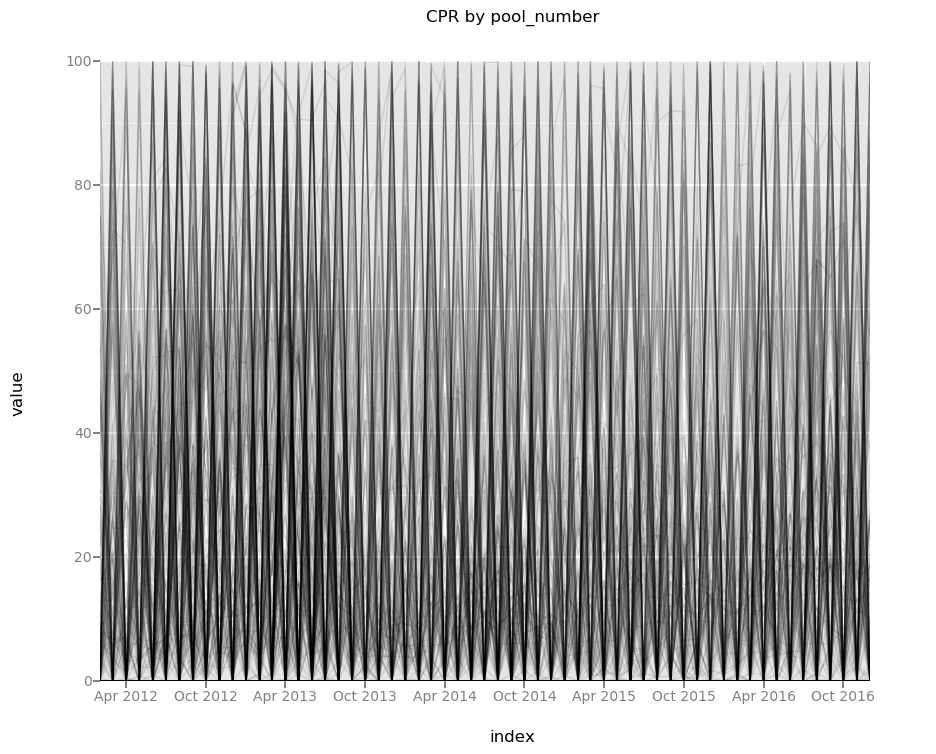

<ggplot: (8754723853849)>

In [81]:
gg.ggplot(pd.core.reshape.melt(pct_upb.apply(smm_to_cpr, axis=1).reset_index(),id_vars=["index"]), 
          gg.aes(x="index",y="value",group="variable")) + gg.geom_line(alpha=0.1) + gg.ggtitle("CPR by pool_number")

Doesn't look great.

I think back to cumulative sum of % upb adjusted to original balance. But does that convert to CPR in any meaningful way?

$$ SMM = \frac{Scheduled\ balance - Ending\ balance}{Scheduled\ balance} * 100 $$

$$ CPR = 1 - (1 - SMM)^{12} * 100 $$

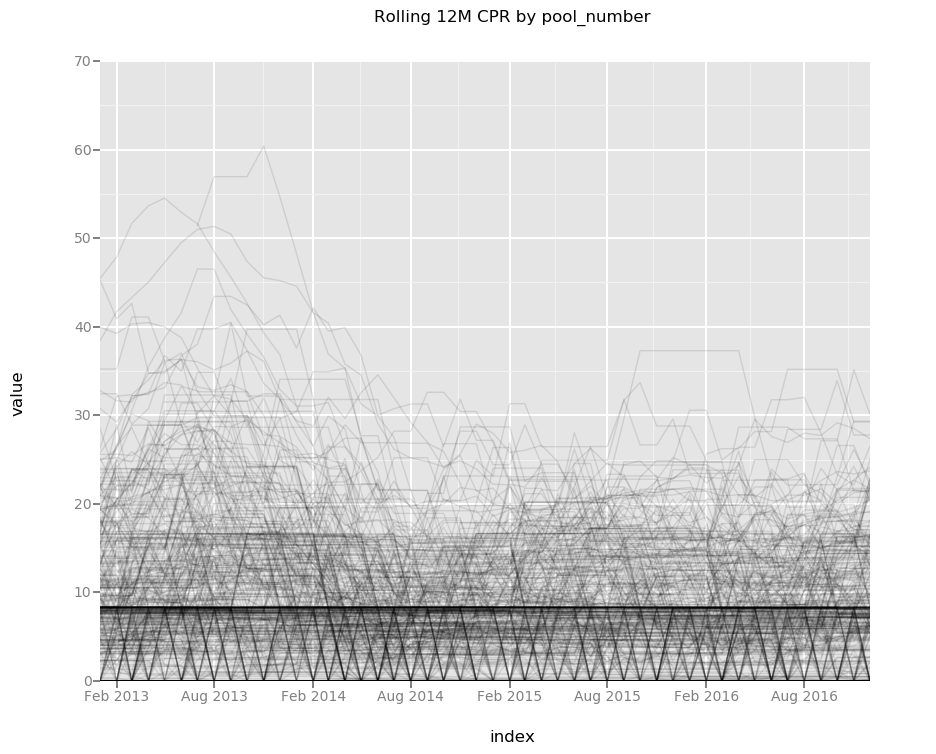

<ggplot: (8754719567597)>

In [84]:
gg.ggplot(pd.core.reshape.melt(pct_upb.apply(smm_to_cpr, axis=1).rolling(12).mean().reset_index(),id_vars=["index"]), 
          gg.aes(x="index",y="value",group="variable")) + gg.geom_line(alpha=0.1) + gg.ggtitle("Rolling 12M CPR by pool_number")

Maybe I should try getting this info from loan-level data?

Otherwise, I think it's ok for cumulative sum of SMM to get over 100%. Given that I'm fitting a probit model at the end of this, I guess I should still try the transform to % prepaid from original value.

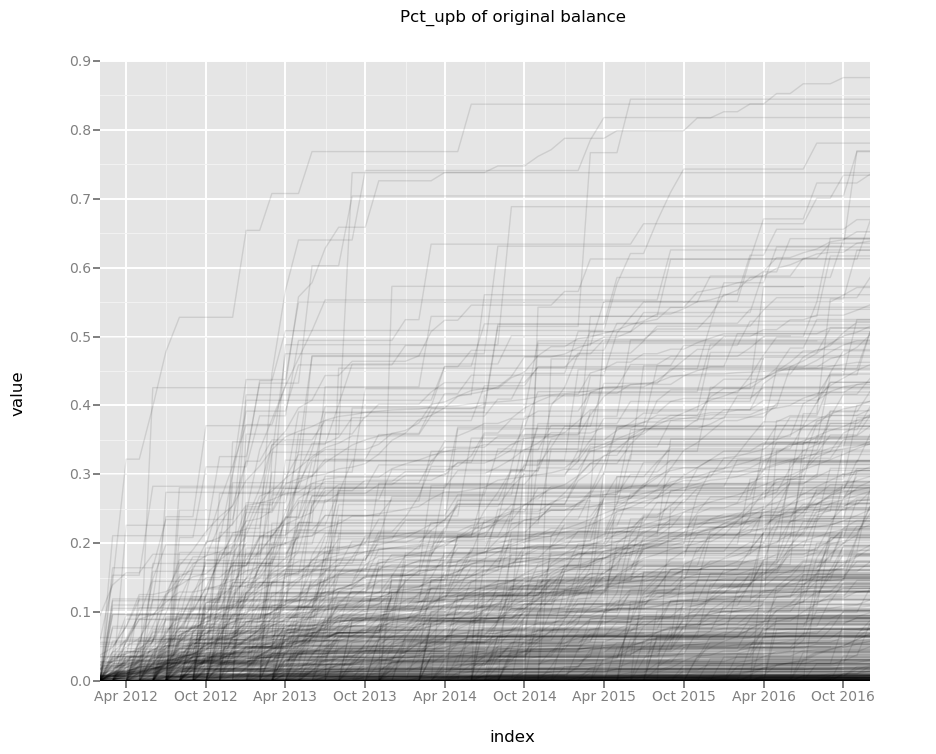

<ggplot: (8754760222177)>

In [91]:
upb_bal = 'unpaid_principal_balance_of_loans_paid_off'
pct_upb = {}
for i,dt in samples:
    pct_upb[i] = {}
    for record in pm.data_pool.pools_table.where("pool_number == '{}'".format(i)):
        original_balance = float(record['original_aggregate_amount'])
        break
    for record in pm.data_pool.variouses_table.where("pool_number == '{}'".format(i)):
        pct_upb[i][pp.models.dt_from_ts(record['as_of_date'])] = record[upb_bal] / original_balance
    pct_upb[i] = pd.Series(pct_upb[i])
pct_upb = pd.DataFrame(pct_upb)

p = gg.ggplot(pd.core.reshape.melt(pct_upb.cumsum().reset_index(),id_vars=["index"]), 
          gg.aes(x="index",y="value",group="variable")) + gg.geom_line(alpha=0.1) 
p + gg.ggtitle("Pct_upb of original balance")

Bingo. I think. How's the distribution look weighted by loan age?

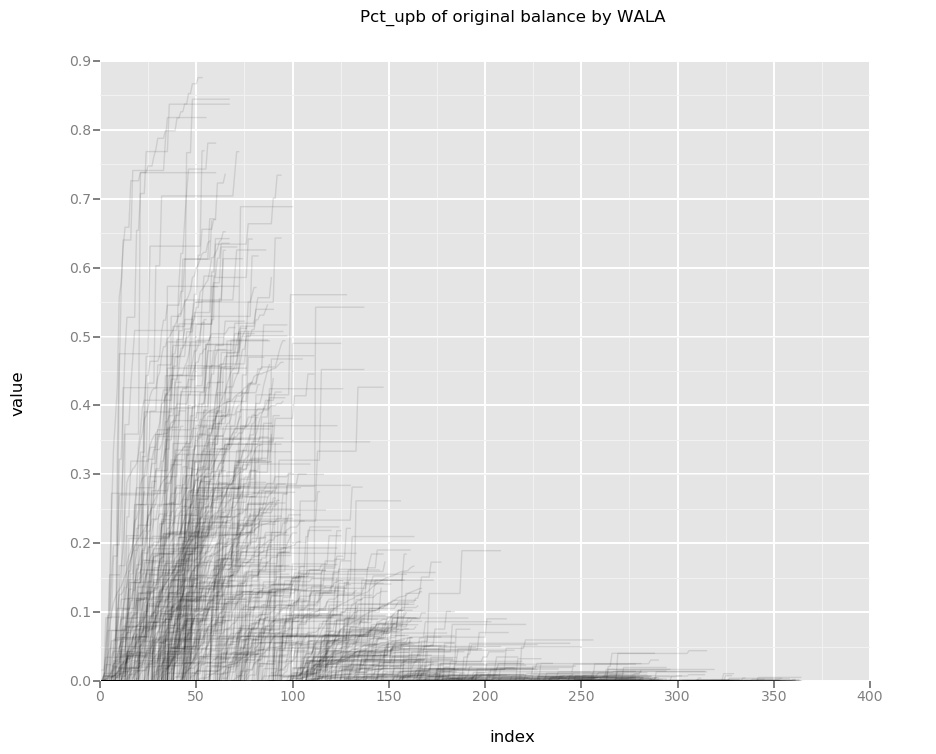

<ggplot: (8754719249109)>

In [114]:
upb_bal = 'unpaid_principal_balance_of_loans_paid_off'
pct_upb = {}
for i,dt in samples:
    pct_upb[i] = {}
    for record in pm.data_pool.pools_table.where("pool_number == '{}'".format(i)):
        original_balance = float(record['original_aggregate_amount'])
        original_dt = pp.models.dt_from_ts(record['pool_issue_date'])
        break
    for record in pm.data_pool.variouses_table.where("pool_number == '{}'".format(i)):
        age = 1 + (pp.models.dt_from_ts(record['as_of_date']) - original_dt).days / 30
        pct_upb[i][age] = record[upb_bal] / original_balance
    pct_upb[i] = pd.Series(pct_upb[i])
pct_upb = pd.DataFrame(pct_upb)
gg.ggplot(pd.core.reshape.melt(pct_upb.cumsum().reset_index(),id_vars=["index"]),
          gg.aes(x='index',y='value',group='variable')) + gg.geom_line(alpha=0.1) + \
          gg.ggtitle("Pct_upb of original balance by WALA")

In [115]:
pct_upb.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 365 entries, 1 to 365
Columns: 1000 entries, 001584 to MA2645
dtypes: float64(1000)
memory usage: 2.8 MB


In [116]:
pct_upb = pct_upb.cumsum().reset_index()
pct_upb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Columns: 1001 entries, index to MA2645
dtypes: float64(1000), int64(1)
memory usage: 2.8 MB


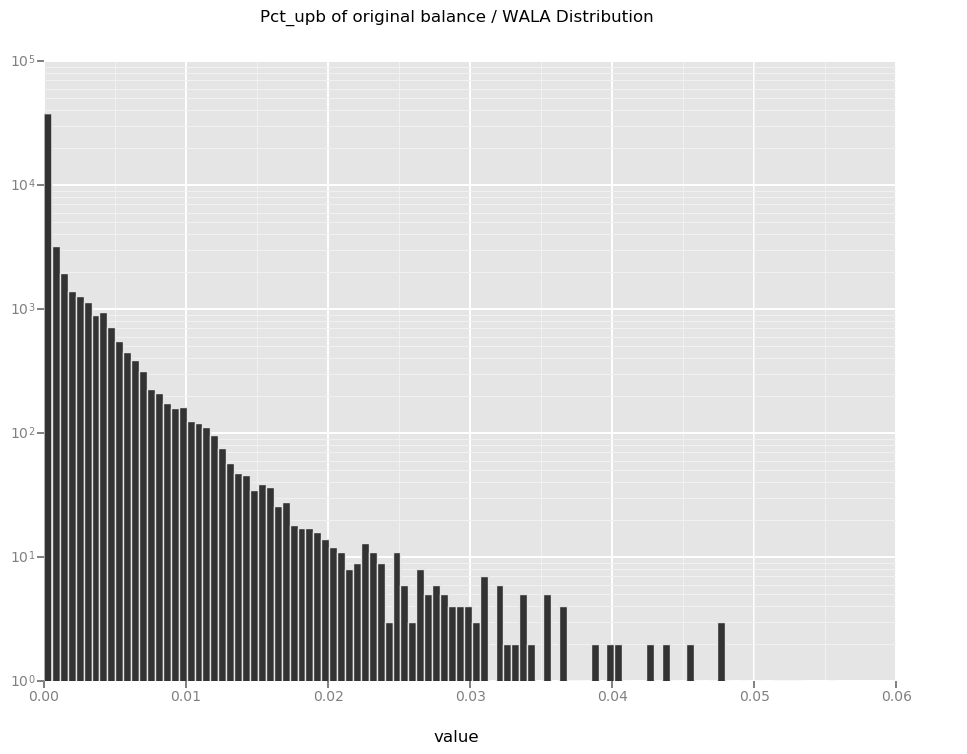

<ggplot: (8754708607397)>

In [123]:
gg.ggplot(pd.core.reshape.melt(pct_upb.apply(lambda x:x / float(x[0]), axis=1),id_vars=["index"]),
          gg.aes(x='value')) + gg.geom_histogram(bins=100) + \
          gg.ggtitle("Pct_upb of original balance / WALA Distribution") + \
          gg.scale_y_log()

Ok, let's proceed with the cumulative sum of pct of original balance. I should do some spot checks on how it relates to CPR from, say, BBG, I guess.

Maybe I don't even need cumulative sum.

In [129]:
import time
jim = pm.data_pool.h5file.root.pools.read_where("(pool_number == '793381') & (as_of_date == {})".format(time.mktime(pd.Timestamp("2014-06-01").timetuple())))

In [130]:
jim

array([ (99999999, 1401595200, '36177MXK3', 0, 0, 0, 99999999, 999, 999, 99999, 99999, 999, 999, 999, 0, 0, 0, 18000, 'Wells Fargo Multifamily Capital         ', 3998, 1, 10000, 431068254, 0, 1, 10000, 431068254, 99999999, 999, 999, 99999, 99999, 999, 999, 999, 99999999, 999, 999, 99999, 99999, 999, 999, 999, 99999999, 999, 999, 99999, 99999, 999, 999, 999, 0, 0, 0, 1, 0, 0, 0, 445650000, 18000, 0, 1343793600, -1845512896, '793381', 'PN', 431068254, 1, 10000, 431068254, 0, 0, 0, 0, 0, 0, 2380, 9999, 99999999, 999, 999, 99999, 99999, 999, 999, 999, 99999, 99999, 999, 999, 999, 999, 99999999, 999)], 
      dtype=[('aols', '<i8'), ('as_of_date', '<i4'), ('cusip', 'S9'), ('few_units_number_of_loans', '<i4'), ('few_units_pct_of_upb', '<i4'), ('few_units_upb', '<i8'), ('first_quartile_aols_q1', '<i8'), ('first_quartile_cltv_q1', '<i2'), ('first_quartile_ltv_q1', '<i2'), ('first_quartile_wac_q1', '<i4'), ('first_quartile_wagm_q1', '<i4'), ('first_quartile_wala_q1', '<i2'), ('first_quartile_wa

In [131]:
jim['wac']

array([99999], dtype=int32)

In [132]:
jim = pm.data_pool.h5file.root.pools.read_where("(pool_number == '793381')")
jim['wac']

array([99999, 99999, 99999, 99999, 99999, 99999, 99999, 99999, 99999,
       99999, 99999, 99999, 99999, 99999, 99999, 99999, 99999, 99999,
       99999, 99999, 99999, 99999, 99999, 99999, 99999, 99999, 99999,
       99999, 99999, 99999, 99999, 99999, 99999, 99999, 99999, 99999,
       99999, 99999, 99999, 99999, 99999, 99999, 99999, 99999, 99999,
       99999, 99999, 99999, 99999, 99999, 99999, 99999, 99999], dtype=int32)

In [133]:
jim

array([ (99999999, 1343793600, '36177MXK3', 999999, 99999, 9999999999999, 99999999, 999, 999, 99999, 99999, 999, 999, 999, 0, 0, 0, 18000, 'Wells Fargo Multifamily Capital         ', 3998, 1, 10000, 445650000, 0, 1, 10000, 445650000, 99999999, 999, 999, 99999, 99999, 999, 999, 999, 99999999, 999, 999, 99999, 99999, 999, 999, 999, 99999999, 999, 999, 99999, 99999, 999, 999, 999, 0, 0, 0, 1, 999999, 99999, 9999999999999, 445650000, 18000, 0, 1343793600, -1845512896, '793381', 'PN', 0, 1, 10000, 445650000, 0, 0, 0, 0, 0, 0, 2380, 9999, 99999999, 999, 999, 99999, 99999, 999, 999, 999, 99999, 99999, 999, 999, 999, 999, 0, 999),
       (99999999, 1346472000, '36177MXK3', 999999, 99999, 9999999999999, 99999999, 999, 999, 99999, 99999, 999, 999, 999, 0, 0, 0, 18000, 'Wells Fargo Multifamily Capital         ', 3998, 1, 10000, 445002318, 0, 1, 10000, 445002318, 99999999, 999, 999, 99999, 99999, 999, 999, 999, 99999999, 999, 999, 99999, 99999, 999, 999, 999, 99999999, 999, 999, 99999, 99999, 999,